In [7]:
import os
import platform
import subprocess
import pandas as pd
import numpy

RUNS = 10

FILENAME = 'CMP.csv'

def system_info():
    print(os.name, platform.system(), platform.release())
    print(os.popen("clinfo | grep -B 2 -A 4 'Device Vendor ID'").read())
    
# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "platform": [], "execution_time_ms": []})
    
# List previous data
df

,execution_time_ms,platform,version
0,481.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
1,347.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
2,300.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
3,289.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
4,289.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
5,287.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
6,289.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
7,283.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
8,285.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL
9,305.0,Intel(R) Iris(TM) Plus Graphics 640,OpenCL


# MacBook Pro (13-inch, 2017)

In [2]:
system_info()

('posix', 'Darwin', '19.4.0')
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel
  Device Vendor ID                                0xffffffff
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.1
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     CPU
--
--
  Device Name                                     Intel(R) Iris(TM) Plus Graphics 640
  Device Vendor                                   Intel Inc.
  Device Vendor ID                                0x1024500
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.2(Mar 15 2020 21:29:48)
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     GPU



# MacBook Pro (13-inch, 2017) + Docker

In [11]:
system_info()

posix Linux 4.19.76-linuxkit
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU



## OpenCL version

In [10]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-ocl2 -aph 600 -c0 1.98e-7 -c1 1.77e-6 -d 2 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "OpenCl/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}))
          
df.to_csv(FILENAME, index = False, header = True)

## OpenMP version

In [13]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-omp2 -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "OpenMP/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenMP"], 
                                 "platform"         : ["Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz"], 
                                 "execution_time_ms": [int(result[0])]}))
          
df.to_csv(FILENAME, index = False, header = True)

## SYCL version (using Docker)

In [ ]:
for i in range(RUNS): 
    run = subprocess.Popen("./cmp-sycl2 -aph 600 -c0 1.98e-7 -c1 1.77e-6 -i ../../../../datasets/simple-synthetic.su -nc 5 -tau 0.002 -v 0",
                           cwd = "SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["SYCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

Text(0, 0.5, 'Execution time (ms)')

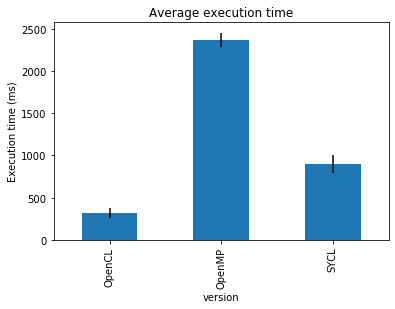

In [9]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df.groupby(by="version", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Average execution time")
plt.set_ylabel("Execution time (ms)")